In [1]:
%matplotlib inline
import random
random.seed(0)
seed=0
import numpy as np
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import scipy.sparse as sps
from scipy.linalg import pinv
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, GridSearchCV, validation_curve

import timeit
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.ensemble import RandomForestClassifier as RFC
from itertools import product
from collections import defaultdict
from sklearn.metrics import  confusion_matrix,adjusted_rand_score
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import homogeneity_score
from sklearn import metrics
from sklearn.decomposition import PCA,FastICA
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import optimizers

Using TensorFlow backend.


## Load data

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

skips = 2
X_train=np.delete(X_train, list(range(0, X_train.shape[1], skips)), axis=1)
X_train=np.delete(X_train, list(range(0, X_train.shape[2], skips)), axis=2)
X_train = X_train.reshape(X_train.shape[0],-1)

X_test = np.delete(X_test, list(range(0, X_test.shape[1], skips)), axis=1)
X_test = np.delete(X_test, list(range(0, X_test.shape[2], skips)), axis=2)
X_test = X_test.reshape(X_test.shape[0],-1)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

idx_train = np.random.choice(60000, size = 10000, replace = False)
idx_test = np.random.choice(10000, size = 1000, replace = False)
X_train, y_train = X_train[idx_train], y_train[idx_train]
X_test, y_test = X_test[idx_test], y_test[idx_test]

In [3]:
X, y = X_train, y_train

In [4]:
def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

## 1. Clustering algorithm

### k-means clustering

In [5]:
def determine_k(K_list, X, y, plot_elbow = True):
    Sum_of_squared_distances = []; sil_scores = []; homo_scores = []; ars = []
    for k in K_list:
        km = KMeans(n_clusters=k, init='k-means++',random_state=0)
        km = km.fit(X)
        Sum_of_squared_distances.append(km.inertia_)
        sil_scores.append(metrics.silhouette_score(X, km.labels_,metric='euclidean'))
        homo_scores.append(metrics.homogeneity_score(y, km.labels_))
        ars.append(metrics.adjusted_mutual_info_score(y, km.labels_))
    
    if(plot_elbow):
    ##Plotting the elbow curve
        plt.plot(K_list, Sum_of_squared_distances, 'bx-')
        plt.grid(True)
        plt.xlabel('k')
        plt.ylabel('Sum_of_squared_distances')
        plt.title('Elbow Method For Optimal k:SSD')
        plt.show()
        
        # elbow curve for silhouette score
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(K_list, sil_scores, 'bx-')
        plt.grid(True)
        plt.xlabel('k')
        plt.ylabel('Avg Silhouette Score')
        plt.title('Elbow Plot for KMeans with Silhouette Score')
        plt.show()
   
        # plot homogeneity scores
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(K_list, homo_scores, 'bx-')
        plt.grid(True)
        plt.xlabel('k')
        plt.ylabel('Homogeneity Score')
        plt.title('Homogeneity Scores vs K')
        plt.show()
        
        #plot Adjusted Rand score
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(K_list, ars, 'bx-')
        plt.grid(True)
        plt.xlabel('k')
        plt.ylabel('Adjusted_rand_score')
        plt.title('Adjusted Rand score vs K')
        plt.show()

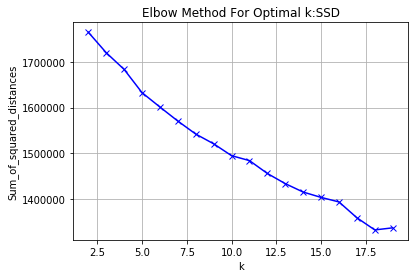

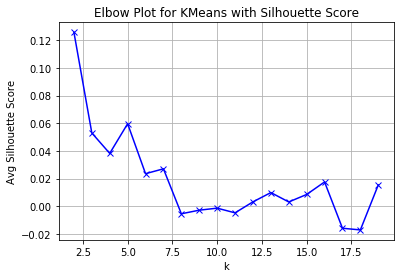

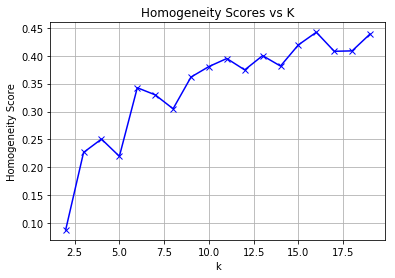

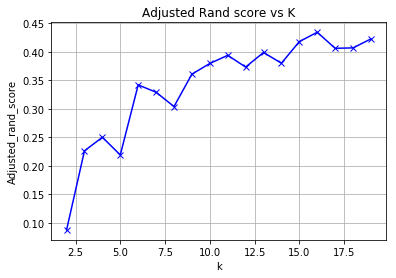

In [6]:
K = list(range(2,20))
determine_k(K,X,y)

### Expectation Maximization

In [7]:
from sklearn.mixture import GaussianMixture as EM
from sklearn.metrics import silhouette_score as sil_score, homogeneity_score
import matplotlib.pyplot as plt

np.random.seed(0)

def run_EM(n_components_list,X, title):
    bic_scores = [];  aic_scores = []; ll = []
    
    for n in n_components_list:
        #start_time = timeit.default_timer()
        em = EM(n_components=n,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(X)
        #end_time = timeit.default_timer()
        #train_times.append(end_time - start_time)
        
        labels = em.predict(X)
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))
        ll.append(em.score(X))
        

    # plot model AIC and BIC
    plt.figure()
    #ax = fig.add_subplot(111)
    plt.grid(True)
    plt.plot(n_components_list, aic_scores,'o-', label='AIC')
    plt.plot(n_components_list, bic_scores,'o-', label='BIC')
    plt.xticks(np.arange(min(n_components_list), max(n_components_list)+1, 2.0))
    plt.xlabel('Number of clusters')
    plt.ylabel('Model Complexity Score')
    plt.title('EM Model Complexity: '+title)
    plt.legend(loc="best")
    plt.show()
    
    
    ##Plot Log Likelihhod
    plt.figure()
    #ax = fig.add_subplot(111)
    plt.grid(True)
    plt.plot(n_components_list, ll,'o-')
    #plt.plot(n_components_list, bic_scores,'o-', label='BIC')
    plt.xticks(np.arange(min(n_components_list), max(n_components_list)+1, 2.0))
    plt.xlabel('Number of clusters')
    plt.ylabel('Log Probability')
    plt.title('EM Log Likelihhod: '+title)
    #plt.legend(loc="best")
    plt.show()

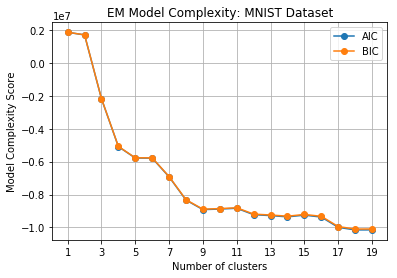

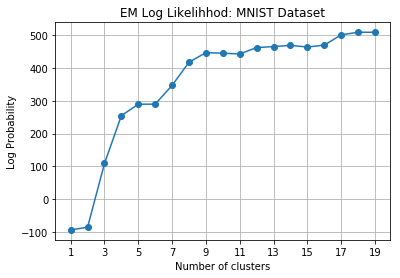

In [8]:
n = list(range(1,20))

run_EM(n,X,'MNIST Dataset')

## Dimensionality reduction algorithms

### PCA

In [9]:
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.ensemble import RandomForestClassifier as RFC
from itertools import product
from collections import defaultdict

def run_PCA(X,y,title):
    
    pca = PCA(random_state=5).fit(X) #for all components
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    plt.figure()
    #ax = fig.add_subplot(111)
    plt.grid(True)
    plt.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-')
    #plt.xticks(np.arange(min(n_components_list), max(n_components_list)+1, 2.0))
    #plt.yticks(cum_var)
    plt.xlabel('Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Explained Variance: '+title)
    #plt.legend(loc="best")
    plt.show()
    
    
    #fig, ax1 = plt.subplots()
    #ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-')
    #ax1.yticks(np.arange(0, 1.1, 1.0))
    #ax1.set_xlabel('Principal Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    #ax1.set_ylabel('Cumulative Explained Variance Ratio', color='b')
    #ax1.tick_params('y', colors='b')
    #plt.grid(False)

    plt.figure()
    plt.grid(True)
    plt.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'm-')
    plt.xlabel('Principal Components')
    plt.ylabel('Eigenvalues')
    plt.title('EigenValues After PCA: '+title)
    #plt.tick_params('y',)
    plt.show()

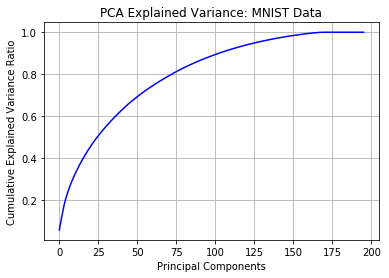

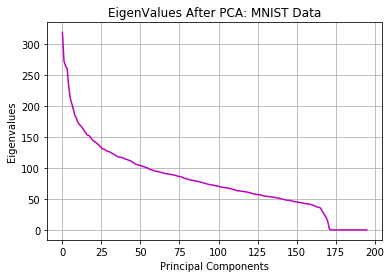

In [10]:
run_PCA(X,y,"MNIST Data")

## ICA

In [11]:
def run_ICA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    ica = ICA(random_state=5)
    kurt = []

    for dim in dims:
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    plt.grid(True)
    plt.show()

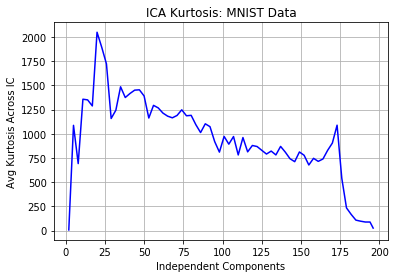

In [12]:
run_ICA(X,y,"MNIST Data")

## Randomized Projections

In [15]:
def run_RCA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),10))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)

    for i,dim in product(range(5),dims):
        rp = RCA(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()
 

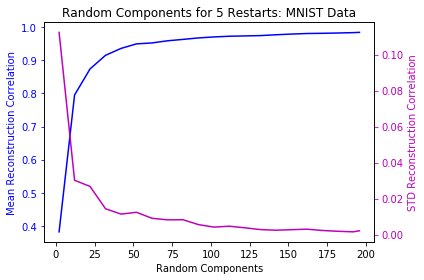

In [16]:
run_RCA(X,y,"MNIST Data")

## RF

In [21]:
def run_RFC(X,y,df_original):
    rfc = RFC(n_estimators=500,min_samples_leaf=round(len(X)*.01),random_state=5,n_jobs=-1)
    imp = rfc.fit(X,y).feature_importances_ 
    imp = pd.DataFrame(imp,columns=['Feature Importance'],index=df_original.columns)
    imp.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    imp['Cum Sum'] = imp['Feature Importance'].cumsum()
    imp = imp[imp['Cum Sum']<=0.95]
    top_cols = imp.index.tolist()
    return imp, top_cols

In [22]:
imp, top_cols = run_RFC(X,y,pd.DataFrame(X))

## Clustering on PCA

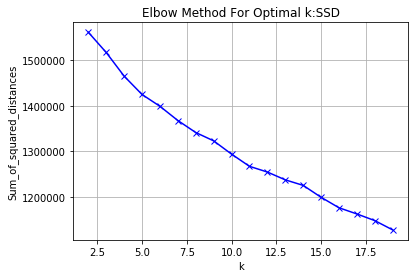

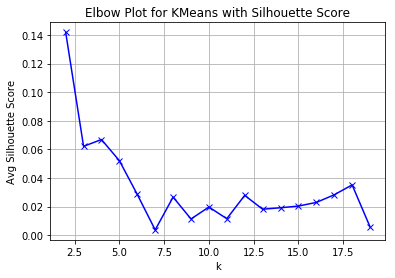

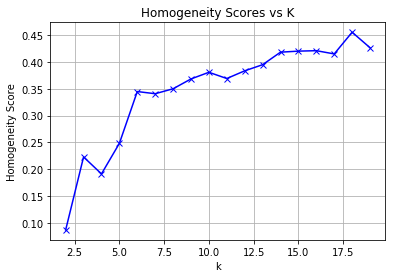

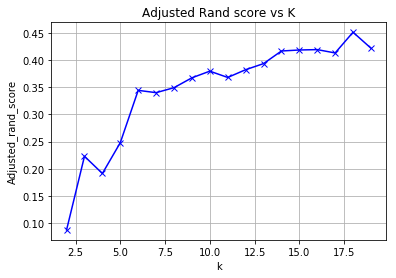

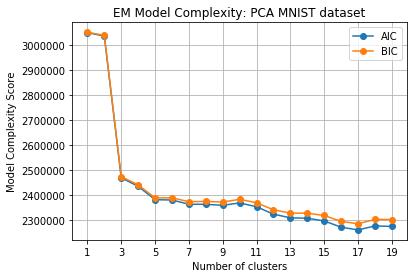

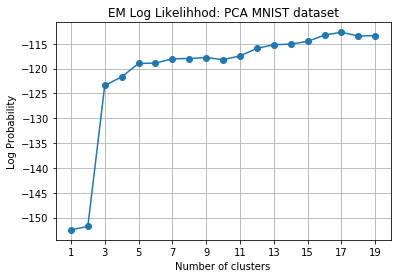

In [24]:
pca_X = PCA(n_components=100,random_state=5).fit_transform(X)
K = list(range(2,20))
determine_k(K,pca_X,y)

n = list(range(1,20))
run_EM(n, pca_X,'PCA MNIST dataset')

## Apply clustering on ICA

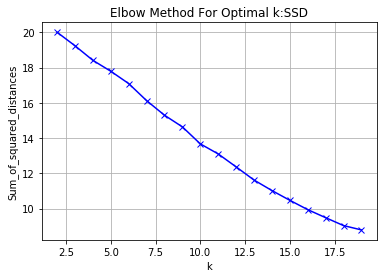

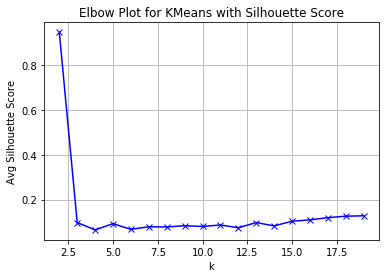

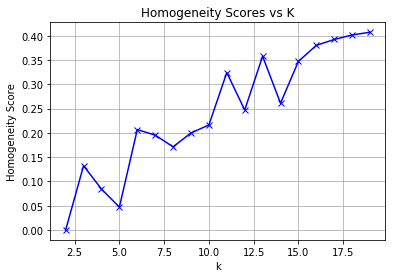

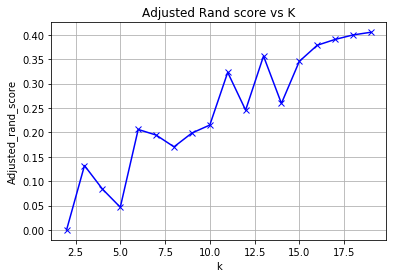

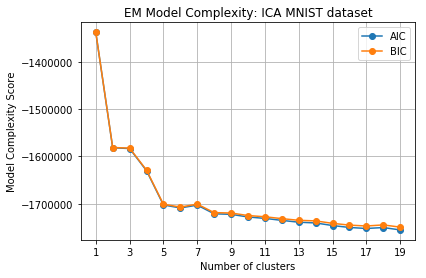

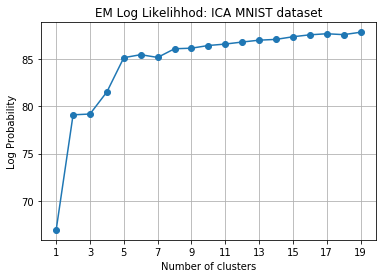

In [25]:
ic_X = FastICA(n_components = 21, random_state= seed).fit_transform(X)

K = list(range(2,20))
determine_k(K,ic_X,y)

n = list(range(1,20))
run_EM(n, ic_X,'ICA MNIST dataset')

## Apply clustering on RP

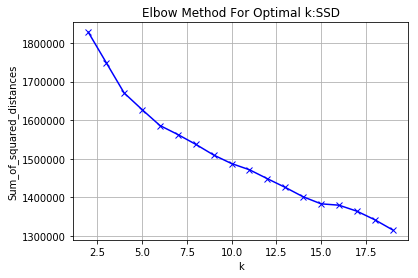

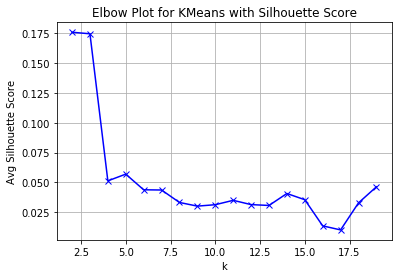

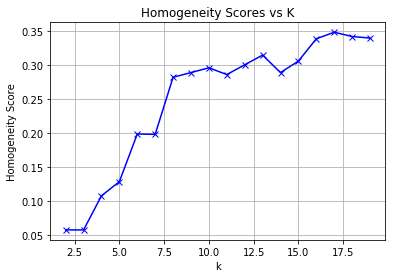

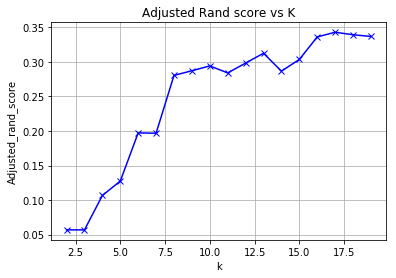

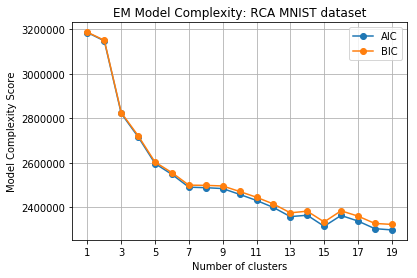

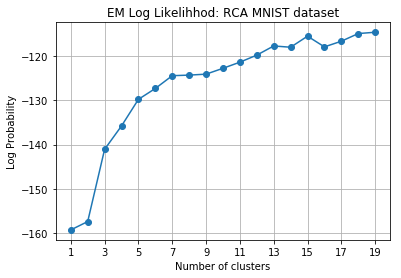

In [26]:
rp_X = RCA(n_components = 90, random_state= seed).fit_transform(X)

K = list(range(2,20))
determine_k(K,rp_X,y)

n = list(range(1,20))
run_EM(n, rp_X,'RCA MNIST dataset')

## Apply clustering on RF

(10000, 67)


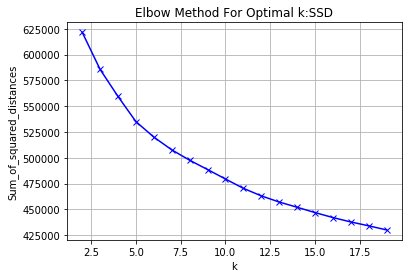

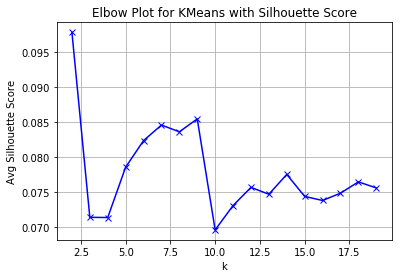

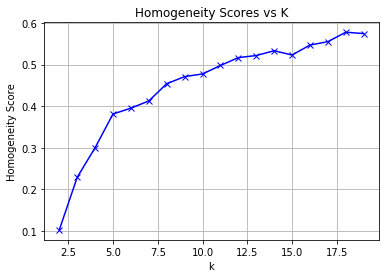

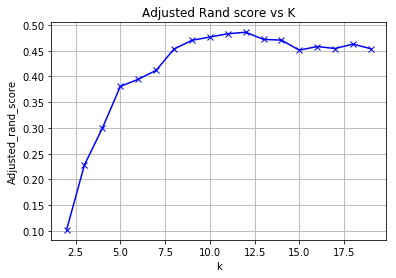

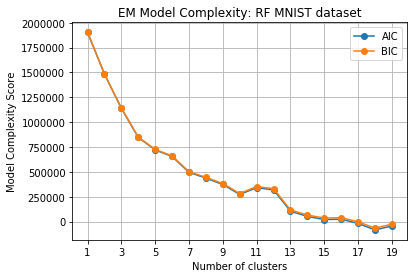

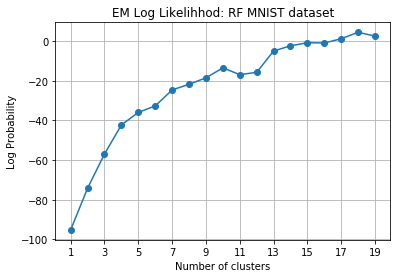

In [27]:
rf_X =  pd.DataFrame(X)[top_cols]
print(rf_X.shape)
K = list(range(2,20))
determine_k(K,rf_X,y)

n = list(range(1,20))
run_EM(n, rf_X,'RF MNIST dataset')

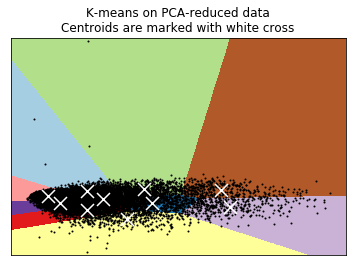

In [30]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means on PCA-reduced data\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

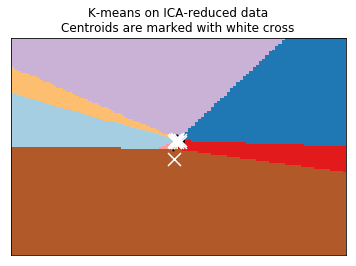

In [31]:
reduced_data = FastICA(n_components = 2, random_state= seed).fit_transform(X)
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means on ICA-reduced data\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

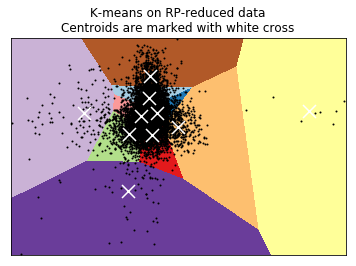

In [32]:
reduced_data = RCA(n_components =2, random_state= seed).fit_transform(X)
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means on RP-reduced data\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

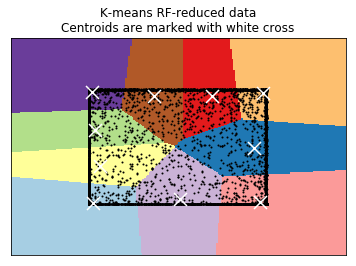

In [34]:
reduced_data = pd.DataFrame(X)[top_cols[:2]].as_matrix()
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means RF-reduced data\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [35]:
len(top_cols)

67